# Imports

In [1]:
import os
import importlib
import load_configs
importlib.reload(load_configs)
openai_api_key = load_configs.openai_api_key
tavily_api_key = load_configs.tavily_api_key
from load_configs import openai_api_key, tavily_api_key
from langchain_openai import OpenAI, ChatOpenAI
from typing import (
    List, Sequence, Tuple, Callable, Optional, Union, Literal,
    TYPE_CHECKING, Any, Annotated
)
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Model

In [2]:
chatmodel = ChatOpenAI(api_key=openai_api_key.get_secret_value(), 
                       model="gpt-4o-mini")
chatmodel.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}, id='run-4158a994-5d5c-400a-8ec8-8a2061b0deb8-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17})

# State as TypedDict

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]  ## The messages key is annotated with the add_messages reducer function, which tells LangGraph to append new messages to the existing list, rather than overwriting it.

s1 = State()
print(s1)

### This dictionary must have a key messages with a value that is a list. 
###Type checkers (like mypy) will enforce this structure.

state_instance: State = {
    "messages": ["Hello", "World"]  
}
print(state_instance) 

## This will raise an error in static type checking tools
state_instance: State = {
    "key_out_side_of_schema": "value not in schema will raise an error by type checking tool"  
    }
print(state_instance)


{}
{'messages': ['Hello', 'World']}
{'key_out_side_of_schema': 'value not in schema will raise an error by type checking tool'}


# StateGraph Graph Builder

In [4]:
graph_builder = StateGraph(State)
##graph_builder has methods to add node , edge 

In [5]:
## create a chatbot node - 
### Every node will receive current state as input and return updated state
def chatbot(state: State):
    node_input = state["messages"]
    node_result = chatmodel.invoke(node_input)
    node_output = {"messages": [node_result]}
    return node_output
try:
    graph_builder.add_node("chatbot", chatbot)
except:
    pass
print(graph_builder.nodes)

{'chatbot': StateNodeSpec(runnable=chatbot(recurse=True), metadata=None, input=<class '__main__.State'>, retry_policy=None)}


In [6]:
graph_builder.add_edge(START, "chatbot") ## ENTRY POINT
graph_builder.add_edge("chatbot", END) ### finish point
graph = graph_builder.compile()
graph

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden'], 'metadata': {}, 'configurable': {}}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<messages>(recurse=True, writes=[ChannelWriteEntry(channel='messages', value=<object object at 0x7fcc6a1c8510>, skip_none=False, mapper=_get_state_key(recurse=False))], require_at_least_one_of=['messages']), ChannelWrite<start:chatbot>(recurse=True, writes=[ChannelWriteEntry(channel='start:chatbot', value='__start__', skip_none=False, mapper=None)], require_at_least_one_of=None)]), 'chatbot': PregelNode(config={'tags': [], 'metadata': {}, 'configurable': {}}, channels={'messages': 'messages'}, triggers=['start:chatbot'], mapper=functools.partial(<function _coerce_state at 0x7fcc69c8eb80>, <class '__main__.State'>), writers=[ChannelWrite<chatbot,messages>(recurse=True, writes=[ChannelWriteEntry(channel='chatbot', value='chatbot', skip_none=False, mapper=None), ChannelWriteEntry(channel='messages'

In [7]:
graph.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'pydantic.v1.main.LangGraphInput'>, metadata=None), 'chatbot': Node(id='chatbot', name='chatbot', data=chatbot(recurse=True), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'pydantic.v1.main.LangGraphOutput'>, metadata=None)}, edges=[Edge(source='__start__', target='chatbot', data=None, conditional=False), Edge(source='chatbot', target='__end__', data=None, conditional=False)])

In [8]:
print(graph.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([__start__]):::first
	chatbot(chatbot)
	__end__([__end__]):::last
	__start__ --> chatbot;
	chatbot --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



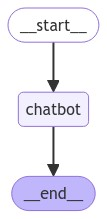

In [9]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass

In [10]:
input_state = {"messages": ("user", "tell me a one line poem on early morning")}
streamed_output_state_from_graph = graph.stream(input_state)
print('streamed_output_state_from_graph type:', type(streamed_output_state_from_graph))
output_state_from_graph = next(streamed_output_state_from_graph)
print('output_state_from_graph:', output_state_from_graph)

streamed_output_state_from_graph type: <class 'generator'>
output_state_from_graph: {'chatbot': {'messages': [AIMessage(content="In dawn's soft blush, the world awakens slow, where whispered dreams and golden sunlight flow.", response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 16, 'total_tokens': 36}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}, id='run-3b1e7e0d-5463-4d4d-a5b6-df28134e3897-0', usage_metadata={'input_tokens': 16, 'output_tokens': 20, 'total_tokens': 36})]}}


In [11]:
chatmodel_output = output_state_from_graph['chatbot']['messages'][-1]
print(chatmodel_output.content)
print(chatmodel_output.usage_metadata)
print(chatmodel_output.response_metadata)

In dawn's soft blush, the world awakens slow, where whispered dreams and golden sunlight flow.
{'input_tokens': 16, 'output_tokens': 20, 'total_tokens': 36}
{'token_usage': {'completion_tokens': 20, 'prompt_tokens': 16, 'total_tokens': 36}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}


In [12]:
input_state = {"messages": ("user", "tell me a one line poem on early morning")}
streamed_output_state_from_graph = graph.stream(input_state)
for event in streamed_output_state_from_graph:
    print(event)

{'chatbot': {'messages': [AIMessage(content='In the hush of dawn, whispers of light dance on dew-kissed dreams.', response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 16, 'total_tokens': 32}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}, id='run-81321721-f3d0-4fde-b72b-5581585a02fd-0', usage_metadata={'input_tokens': 16, 'output_tokens': 16, 'total_tokens': 32})]}}


In [13]:
graph.invoke(input_state)

{'messages': [HumanMessage(content='tell me a one line poem on early morning', id='cc93a36c-3314-4658-83c4-f6f2e8cb1f95'),
  AIMessage(content="In dawn's soft glow, the world awakens, kissed by whispers of light.", response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 16, 'total_tokens': 33}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}, id='run-03820edd-50eb-4bf7-8d75-f0738d42cf2f-0', usage_metadata={'input_tokens': 16, 'output_tokens': 17, 'total_tokens': 33})]}

In [14]:
from langchain_core.messages import (HumanMessage, SystemMessage, AIMessage)
input_state = {"messages": (HumanMessage("tell me a one line poem on early morning"))}
graph.invoke(input_state)

{'messages': [HumanMessage(content='tell me a one line poem on early morning', id='1d6b584a-bc77-4a75-a67c-15abe06f5bdc'),
  AIMessage(content="In dawn's soft whisper, dreams dissolve like mist.", response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 16, 'total_tokens': 27}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}, id='run-a201e1ff-d680-4364-8a50-a02b391cc1a2-0', usage_metadata={'input_tokens': 16, 'output_tokens': 11, 'total_tokens': 27})]}

# we can run this graph in a while loop to act like a chatbot

In [15]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        break
    else:
        user_input = {"messages": ("user", user_input)}
    streamed_output_state_from_graph = graph.stream(user_input) 
    output_state_from_graph = next(streamed_output_state_from_graph)
    chatmodel_output = output_state_from_graph['chatbot']['messages'][-1]
    print(chatmodel_output.content)
    print(chatmodel_output.usage_metadata)    


User:  hi


Hello! How can I assist you today?
{'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17}


User:  quit


# Integrating tool

##  initialize tavily tool

In [38]:
os.environ['TAVILY_API_KEY'] = tavily_api_key.get_secret_value()
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=2, #### response_format='content_and_artifact' this tool did not have support for artifact
                                   )
tavily_search.invoke("what is the ITC share price today ")

[{'url': 'https://economictimes.indiatimes.com/itc-ltd/stocks/companyid-13554.cms',
  'content': 'ITC Share Price Today (21 Aug, 2024): ITC Stock Price (₹ 505.40) Live NSE/BSE updates on The Economic Times. Check out why ITC share price is up today. Get all details on ITC Ltd.shares news and analysis, Forecasts, Dividend, balance sheet, profit & loss, Quarterly results, annual report information, and more ...'},
 {'url': 'https://ticker.finology.in/company/ITC',
  'content': 'ITC Ltd. Share Price Today: CLOSE 498.8, HIGH 503.4, LOW: 497.7. Get latest balance sheet, annual reports, quarterly results, and price chart.'}]

In [17]:
tools = [tavily_search]

##  bind tool with model

In [18]:
chatmodel_with_tools = chatmodel.bind_tools(tools)
chatmodel_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7fcc69c34760>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7fcc69c45910>, model_name='gpt-4o-mini', openai_api_key=SecretStr('**********'), openai_proxy=''), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type': 'object', 'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query']}}}]})

##  rebuild the graph with new node as chatmodel_with_tools

In [19]:
graph_builder = StateGraph(State)

def chatbot(state: State):
    node_input = state["messages"]
    node_result = chatmodel_with_tools.invoke(node_input)
    node_output = {"messages": [node_result]}
    return node_output
try:
    graph_builder.add_node("chatbot", chatbot)
except:
    pass


## tool execution environment - takes AIMessage , take tool_call attribute and invoke all the tools

 the model has determinied what all tool to call hence we have to now call all the tool present in the AIMessage

In [40]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    ''' A node that runs the tools requested in the last AIMessage'''

    def __init__(self, tools: list) -> None:
        self.tools_dict = {tool.name: tool for tool in tools} ## converting all the tools as a dict 

    def __call__(self, inputs: dict):
        #### GET THE LAST MESSAGE
        messages = inputs.get("messages", []) #### walrus operator  if messages := inputs.get("messages", [])
        if messages:
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:   ### AIMessage will have an attribute name tool_calls
                    #  tool_call format ->        {
                    #     "name": "calculate_revenue_tool",
                    #     "args": {"product_name": "mechanical keyboard"},
                    #     "id": "1" , ## required field
                    #     "type": "tool_call", ## required field
                    # }
            tool_name = tool_call.get('name')            
            tool_result = self.tools_dict[tool_name].invoke(
                # tool_call.get('args')  ### This will only provide the result and we have to reformat it as ToolMessage
                tool_call  #### this should provide me ToolMessage  with content and artifact if the tool have support for artifact
                )
            outputs.append(tool_result)
            # outputs.append(
            #     ToolMessage(
            #         content= json.dumps(tool_result),  #{"tool_result": tool_result}
            #         artifact={},
            #         name=tool_name, 
            #         tool_call_id=tool_call['id']
            #     )
            # )
        final_out =  {"messages": outputs} 
        return final_out
                        
tool_node = BasicToolNode(tools=tools)

In [21]:
chatmodel_with_tools.invoke('hi')

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 80, 'total_tokens': 90}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}, id='run-2041f479-e4d1-4b58-931a-f290d1cd3cd4-0', usage_metadata={'input_tokens': 80, 'output_tokens': 10, 'total_tokens': 90})

In [22]:
aimsg = chatmodel_with_tools.invoke('what is the ITC share price today?')
aimsg

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8BfjzaJd8cSXZQC7JnKVEIdI', 'function': {'arguments': '{"query":"ITC share price today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 88, 'total_tokens': 110}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5be2a96c-0a0d-42c5-8e53-8a6c7066ca7e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'ITC share price today'}, 'id': 'call_8BfjzaJd8cSXZQC7JnKVEIdI', 'type': 'tool_call'}], usage_metadata={'input_tokens': 88, 'output_tokens': 22, 'total_tokens': 110})

In [41]:
tool_node({"messages": [aimsg]})

{'messages': [ToolMessage(content=[{'url': 'https://economictimes.indiatimes.com/itc-ltd/stocks/companyid-13554.cms', 'content': 'ITC Share Price Today (21 Aug, 2024): ITC Stock Price (₹ 505.40) Live NSE/BSE updates on The Economic Times. Check out why ITC share price is up today. Get all details on ITC shares news and analysis, Forecasts, Dividend, balance sheet, profit & loss, Quarterly results, annual report information, and more'}, {'url': 'https://www.nseindia.com/get-quotes/equity?symbol=ITC', 'content': 'ITC Limited Share Price Today, Live NSE Stock Price: Get the latest ITC Limited news, company updates, quotes, offers, annual financial reports, graph, volumes, 52 week high low, buy sell tips, balance sheet, historical charts, market performance, capitalisation, dividends, volume, profit and loss account, research, results and more details at NSE India.'}], name='tavily_search_results_json', tool_call_id='call_8BfjzaJd8cSXZQC7JnKVEIdI')]}

## add the tool execution node in the graph

In [42]:
graph_builder.add_node("tools", tool_node)

# Other 